Optimization terminated successfully    (Exit mode 0)
            Current function value: 4932.908284476487
            Iterations: 620
            Function evaluations: 124419
            Gradient evaluations: 619

===== Optimal Solution =====
Total Profit: 4932.91
Optimal Stake S*: [   0.      0.      0.      0.      0.      0.   1242.13    0.      0.
    0.   1198.27    0.      0.      0.      0.      0.      0.      0.
    0.      0.      0.   1081.2     0.      0.      0.      0.    995.02
    0.      0.   1226.85    0.      0.   1203.63    0.      0.      0.
    0.   1166.59    0.      0.   1103.74    0.   1259.33    0.      0.
    0.      0.      0.      0.      0.      0.      0.      0.      0.
    0.      0.   1147.63    0.   1102.65    0.      0.      0.      0.
    0.      0.      0.    349.02    0.   1232.33    0.      0.      0.
 1260.66    0.      0.      0.      0.   1238.25    0.   1091.45    0.
    0.      0.   1120.52    0.      0.      0.      0.      0.      0.
 10

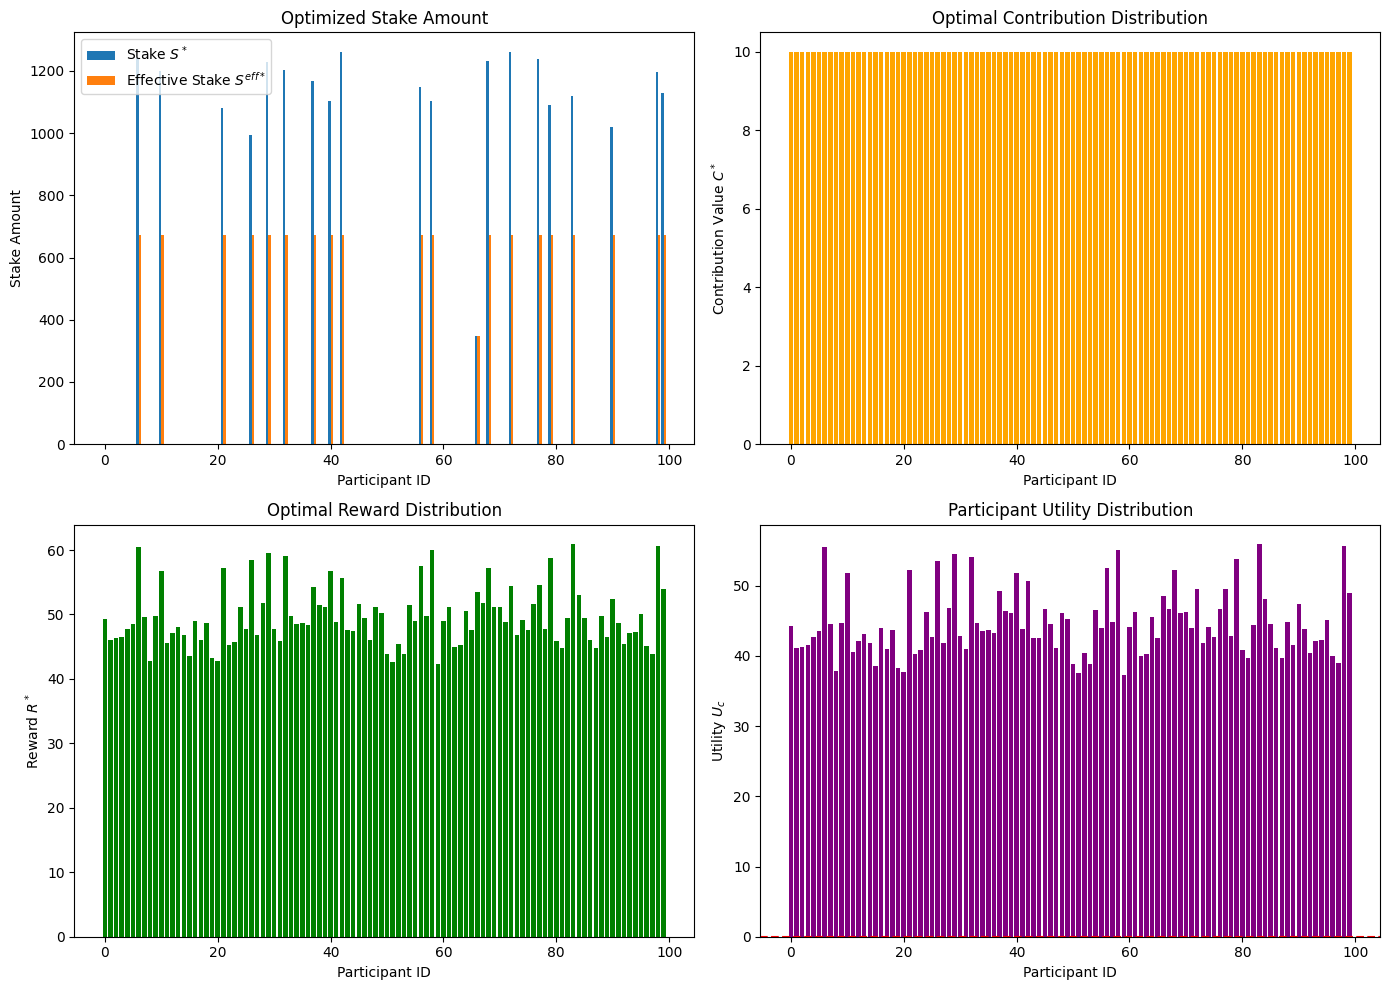

In [27]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

###############################
#### Parameter Settings (Adjustable) ####
###############################
N = 100                  # Number of participants
Xc = 2                  # Contribution value coefficient
tau = 5                  # Task completion time
k = 1.0                  # Sensitivity of the contribution quality function (higher value increases sensitivity)
lambda_stake = 0.4       # Global stake weight
B_rw = 1000              # Base reward pool
J_r = 1                # Fairness factor
R_cmm = 40               # Committee reward
zeta = 0.9               # Historical contribution decay factor
tau_rounds = 5           # Number of historical contribution rounds
gamma = 0.1              # Effort cost coefficient
max_C = 10               # Maximum contribution value (C ∈ [0, 10])
penalty_coeff = 1e6      # IR constraint penalty coefficient
Cmin = 0                 # Minimum contribution value
Cmax = 10                # Maximum contribution value

np.random.seed(42)       # Fix random seed

########################################
#### Initialize Participants' Attributes and Historical Contributions ####
########################################

# Generate initial participant attributes
def initialize_participants(N):
    """Generate initial attributes for participants: reputation, stake amount, historical contribution"""
    r = np.random.uniform(0.5, 1.0, N)          # Reputation values
    S = np.random.randint(50, 500, N)           # Stake amount
    S[0] = 500                                  # Add a large node (for anti-monopoly testing)
    C_hist = np.zeros(N)
    for i in range(N):
        # Generate historical contributions for the last tau_rounds rounds (with exponential decay, recent rounds have higher weights)
        past_contributions = np.random.randint(0, max_C, tau_rounds)
        decay_weights = zeta ** np.arange(0, tau_rounds)  # [zeta^0, zeta^1, ..., zeta^(tau_rounds-1)]
        C_hist[i] = np.sum(past_contributions * decay_weights)
    return r, S, C_hist

# Initialize participants
r, S_init, C_hist = initialize_participants(N)
C_total = np.sum(C_hist)                        # Total historical contribution
r_i0 = np.mean(r)                               # Baseline reputation

########################################
#### Core Function Definitions (Aligned with Theoretical Model) ####
########################################

def compute_S_eff(S):
    """Compute effective stake: S_eff = min(S_i, 3*mean(S))"""
    S_bar = np.mean(S)
    return np.minimum(S, 3 * S_bar)

def compute_alpha(r, r_i0, f_scale=0.5):
    """Compute dynamic weight α: σ((r - r_i0)/f_scale) * lambda_stake"""
    x = (r - r_i0) / f_scale
    sigmoid = 1 / (1 + np.exp(-x))
    return sigmoid * lambda_stake

def compute_reward(S, C, C_hist, C_total):
    """Compute reward R_i (handling zero contributions)"""
    S_eff = compute_S_eff(S)
    total_S_eff = np.sum(S_eff)
    alpha = compute_alpha(r, r_i0)
    beta = 1 - alpha
    
    # Handling zero contributions (if current or historical contribution is zero, reward is zero)
    mask = (C == 0) | (C_hist == 0)
    R = np.zeros(N)
    for i in range(N):
        if not mask[i]:
            term1 = alpha[i] * B_rw * (S_eff[i] / total_S_eff)
            term2 = beta[i] * B_rw * (C_hist[i] / C_total)
            R[i] = (term1 + term2) * J_r + R_cmm
    return R

def value_function(C):
    """Task publisher's value function: V(C) = Xc/τ * q(C)"""
    normalized_C = (C - Cmin) / (Cmax - Cmin)  # Normalize to [0,1]
    q = 1 / (1 + np.exp(-k * normalized_C))    # Sigmoid response
    return (Xc / tau) * q

def cost_function(C):
    """Participant's effort cost function: c(C) = 0.5*γ*C²"""
    return 0.5 * gamma * C**2

########################################
#### Optimization Problem Definition (Profit Maximization) ####
########################################

def objective(x):
    """Objective function: Maximize total profit (with IR constraint penalty)"""
    # Parse variables: x[0:N] = S_i, x[N:2N] = C_i
    S = x[0:N]
    C = x[N:2*N]
    
    # Compute rewards
    R = compute_reward(S, C, C_hist, C_total)
    
    # Compute profit (V(C) - R)
    V = value_function(C)
    profit = np.sum(V - R)
    
    # Compute IR constraint penalty term (U_c = R - c(C) ≥ 0)
    U_c = R - cost_function(C)
    penalty = np.sum(np.maximum(-U_c, 0)) * penalty_coeff
    
    return -profit + penalty  # Minimize negative profit

# Initial guess (initial values for S and C)
x0 = np.concatenate([S_init, np.random.uniform(0, max_C, N)])

# Define bounds (S ≥ 0, C ∈ [0, max_C])
bounds = [(0, None)] * N + [(0, max_C)] * N

# Optimization solver
result = minimize(
    objective, x0, 
    bounds=bounds, 
    method='SLSQP',  # Suitable for constrained optimization
    options={'maxiter': 1000, 'disp': True}
)

# Parse optimal solution
S_opt = result.x[0:N]
C_opt = result.x[N:2*N]
R_opt = compute_reward(S_opt, C_opt, C_hist, C_total)

##########################
#### Results & Visualization ####
##########################

print("\n===== Optimal Solution =====")
print(f"Total Profit: {result.fun:.2f}")
print("Optimal Stake S*:", S_opt.round(2))
print("Effective Stake S_eff*:", compute_S_eff(S_opt).round(2))
print("Optimal Contribution C*:", C_opt.round(2))
print("Optimal Reward R*:", R_opt.round(2))

# Verify IR constraints
U_c = R_opt - cost_function(C_opt)
print("\n===== Constraint Verification =====")
print(f"IR Constraint Satisfaction Rate: {100*np.mean(U_c >= 0):.1f}%")
print(f"Minimum Utility: {U_c.min():.2f}")

# Visualization of results
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

# 1. Stake and Contribution Distribution
ax[0,0].bar(np.arange(N)-0.2, S_opt, width=0.4, label='Stake $S^*$')
ax[0,0].bar(np.arange(N)+0.2, compute_S_eff(S_opt), width=0.4, label='Effective Stake $S^{eff*}$')
ax[0,0].set_title("Optimized Stake Amount")
ax[0,0].set_xlabel("Participant ID")
ax[0,0].set_ylabel("Stake Amount")
ax[0,0].legend()

ax[0,1].bar(range(N), C_opt, color='orange')
ax[0,1].set_title("Optimal Contribution Distribution")
ax[0,1].set_xlabel("Participant ID")
ax[0,1].set_ylabel("Contribution Value $C^*$")

# 2. Reward and Utility Distribution
ax[1,0].bar(range(N), R_opt, color='green')
ax[1,0].set_title("Optimal Reward Distribution")
ax[1,0].set_xlabel("Participant ID")
ax[1,0].set_ylabel("Reward $R^*$")

ax[1,1].bar(range(N), U_c, color='purple')
ax[1,1].axhline(0, color='red', linestyle='--')
ax[1,1].set_title("Participant Utility Distribution")
ax[1,1].set_xlabel("Participant ID")
ax[1,1].set_ylabel("Utility $U_c$")

plt.tight_layout()
plt.show()
